Import the necessary libraries and modules:

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

Load the dataset from a CSV file:

In [54]:
dataset = pd.read_csv('./lecture_data_new.csv')

Preprocess the dataset

In [55]:
questions = dataset['Question'].values
answers = dataset['Answer'].values
marks = dataset['Marks'].values

Convert the questions and answers to numerical sequences

In [56]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(questions)
questions_seq = tokenizer.texts_to_sequences(questions)
answers_seq = tokenizer.texts_to_sequences(answers)

Pad the sequences to have a fixed length

In [57]:
max_seq_length = max(max(len(q), len(a)) for q, a in zip(questions_seq, answers_seq))
questions_seq = tf.keras.preprocessing.sequence.pad_sequences(questions_seq, maxlen=max_seq_length)
answers_seq = tf.keras.preprocessing.sequence.pad_sequences(answers_seq, maxlen=max_seq_length)

Convert marks to a binary classification problem (pass/fail)

In [58]:
marks_binary = (marks >= 5).astype(int)

Split the dataset into training and testing sets:

In [59]:
split_ratio = 0.9
split_index = int(len(questions) * split_ratio)

train_questions = questions_seq[:split_index]
train_answers = answers_seq[:split_index]
train_marks = marks_binary[:split_index]

test_questions = questions_seq[split_index:]
test_answers = answers_seq[split_index:]
test_marks = marks_binary[split_index:]

Build the RNN model using the functional API

In [60]:
input_questions = Input(shape=(max_seq_length,))
input_answers = Input(shape=(max_seq_length,))

embedding_layer = Embedding(len(tokenizer.word_index) + 1, 32)
embedded_questions = embedding_layer(input_questions)
embedded_answers = embedding_layer(input_answers)

lstm_layer = LSTM(64)
lstm_questions = lstm_layer(embedded_questions)
lstm_answers = lstm_layer(embedded_answers)

concatenated = Concatenate()([lstm_questions, lstm_answers])
dropout = Dropout(0.2)(concatenated)
output_layer = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=[input_questions, input_answers], outputs=output_layer)

Compile the model

In [61]:
model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])

Train the model

In [63]:
history = model.fit([train_questions, train_answers], train_marks, epochs=29, batch_size=96, validation_data=([test_questions, test_answers], test_marks))

Epoch 1/29
3/3 [==============================] - 0s 24ms/step - loss: 0.5470 - accuracy: 0.7233 - val_loss: 0.5865 - val_accuracy: 0.6522
Epoch 2/29
3/3 [==============================] - 0s 19ms/step - loss: 0.5442 - accuracy: 0.7136 - val_loss: 0.5859 - val_accuracy: 0.6087
Epoch 3/29
3/3 [==============================] - 0s 16ms/step - loss: 0.5324 - accuracy: 0.7039 - val_loss: 0.5968 - val_accuracy: 0.6087
Epoch 4/29
3/3 [==============================] - 0s 15ms/step - loss: 0.5370 - accuracy: 0.6748 - val_loss: 0.5787 - val_accuracy: 0.6522
Epoch 5/29
3/3 [==============================] - 0s 14ms/step - loss: 0.5299 - accuracy: 0.7136 - val_loss: 0.5627 - val_accuracy: 0.5652
Epoch 6/29
3/3 [==============================] - 0s 16ms/step - loss: 0.5240 - accuracy: 0.7379 - val_loss: 0.5520 - val_accuracy: 0.6957
Epoch 7/29
3/3 [==============================] - 0s 16ms/step - loss: 0.5272 - accuracy: 0.7330 - val_loss: 0.5525 - val_accuracy: 0.6087
Epoch 8/29
3/3 [===========

Plot the training and validation loss

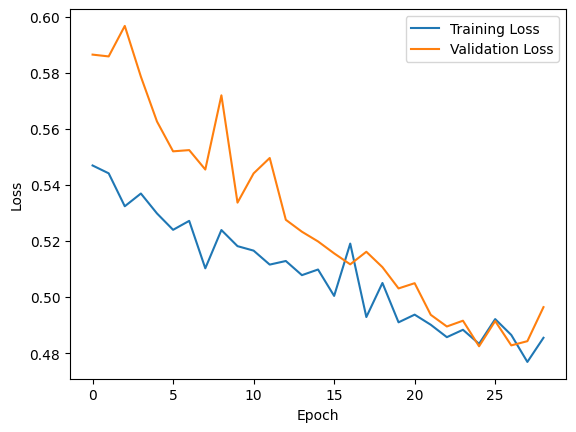

In [64]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the training and validation accuracy

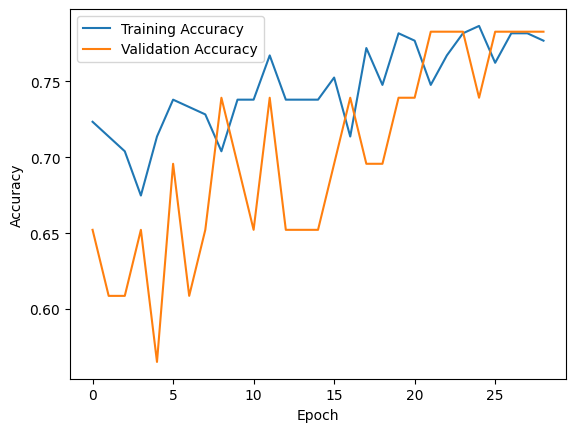

In [65]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [66]:
model.save('trained_model_best_02.h5')
print("Model saved successfully.")

Model saved successfully.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluate the model on the test set:

In [67]:
loss, accuracy = model.evaluate([test_questions, test_answers], test_marks)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

1/1 [==============================] - 0s 15ms/step - loss: 0.4964 - accuracy: 0.7826
Test loss: 0.4964
Test accuracy: 0.7826


Grade new student answers

In [93]:
new_student_question = "What is a website?"
new_student_answer = "A website is a collection of web pages and related content that is identified by a common domain name and published on at least one web server."

Convert the new student question and answer to numerical sequences

In [94]:
new_student_question_seq = tokenizer.texts_to_sequences([new_student_question])
new_student_answer_seq = tokenizer.texts_to_sequences([new_student_answer])

Load the saved model from the local directory

In [95]:
local_model = load_model('./trained_model_best_02.h5')

Pad the sequences to have a fixed length

In [96]:
max_seq_length = local_model.input_shape[0][1]
new_student_question_seq = tf.keras.preprocessing.sequence.pad_sequences(new_student_question_seq, maxlen=max_seq_length)
new_student_answer_seq = tf.keras.preprocessing.sequence.pad_sequences(new_student_answer_seq, maxlen=max_seq_length)

Predict the mark for the new student answer

In [97]:
predicted_mark = local_model.predict([new_student_question_seq, new_student_answer_seq])
predicted_mark = predicted_mark.squeeze() * 10.0

print(f'Predicted mark for the new student answer: {predicted_mark:.1f}/10')

1/1 [==============================] - 0s 268ms/step
Predicted mark for the new student answer: 10.0/10
